Copyright (C) 2019-2021  Martin Engqvist

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.
This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.
You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.

## A notebook to visualize the dbCAN search results on a phylogenetic tree

In [1]:
import sys
import os
from dotenv import load_dotenv, find_dotenv # do 'pip install python-dotenv'
from os.path import join, dirname, basename, exists, isdir


### Load environmental variables from the project root directory ###
# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()

# load up the entries as environment variables
load_dotenv(dotenv_path)

# now you can get the variables using their names

# Check whether a network drive has been specified
DATABASE = os.environ.get("NETWORK_URL")
if DATABASE == 'None':
    pass
else:
    pass
    #mount network drive here

# set up directory paths
CURRENT_DIR = os.getcwd()
PROJ = dirname(dotenv_path) # project root directory

DATA = join(PROJ, 'data') #data directory
RAW_EXTERNAL = join(DATA, 'raw_external') # external data raw directory
RAW_INTERNAL = join(DATA, 'raw_internal') # internal data raw directory
INTERMEDIATE = join(DATA, 'intermediate') # intermediate data directory
FINAL = join(DATA, 'final') # final data directory
FIGURES = join(PROJ, 'figures') # figure output directory
   


    

In [2]:
#from orgtools import topfunctions, org_tax, uid_tax
from ete3 import Tree, NodeStyle, TextFace, TreeStyle
import ete3

import pandas as pd
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

import scipy
import scipy.cluster.hierarchy as sch

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 8}

matplotlib.rc('font', **font)

In [3]:
print('Python version: %s' % (sys.version))
print('Pandas version: %s' % pd.__version__)
print('Matplotlib version: %s' % matplotlib.__version__)
print('ETE3 version: %s' % ete3.__version__)

Python version: 3.7.7 (default, Sep 11 2020, 20:43:12) 
[GCC 7.3.0]
Pandas version: 1.0.3
Matplotlib version: 3.3.2
ETE3 version: 3.1.2


## Visualize strain enzyme data

#### First load the data

In [4]:
df = pd.read_csv(join(FINAL, '332_yeast_genomes_enzyme_info_version_3.tsv'), sep='\t')

display(df.dtypes)
display(df.head())
display(df.tail())
display(df.describe())

organism                object
gene                    object
hmm_model               object
hmm_model_len            int64
hmm_match_from           int64
hmm_match_to             int64
hmm_match_coverage     float64
match_evalue           float64
gene_match_from          int64
gene_match_to            int64
enzyme                  object
family                  object
enzyme_type             object
signal_peptide          object
signal_peptide_prob    float64
sp_cut_pos              object
sp_cut_seq              object
sp_cut_prob            float64
genes_in_fasta           int64
dtype: object

,organism,gene,hmm_model,hmm_model_len,hmm_match_from,hmm_match_to,hmm_match_coverage,match_evalue,gene_match_from,gene_match_to,enzyme,family,enzyme_type,signal_peptide,signal_peptide_prob,sp_cut_pos,sp_cut_seq,sp_cut_prob,genes_in_fasta
0,starmerella_bombicola,-augustus-gene-0.1-mRNA-1_1_gene=maker-gi|1002...,GT15.hmm,273,4,272,0.98,2.500000e-218,47,310,GT15,GT15,GT,OTHER,0.055799,NaN,NaN,NaN,4704
1,starmerella_bombicola,-augustus-gene-0.1-mRNA-1_1_gene=maker-gi|1002...,GT15.hmm,273,1,272,0.99,2.500000e-218,442,712,GT15,GT15,GT,OTHER,0.055799,NaN,NaN,NaN,4704
2,candida_succiphila,-augustus-gene-0.117-mRNA-1_1_gene=maker-gi|10...,GH5_9.hmm,303,1,303,1.00,2.500000e-119,561,873,GH5_9,GH5,GH,OTHER,0.001219,NaN,NaN,NaN,5247
3,saprochaete_clavata,-augustus-gene-0.118-mRNA-1_1_gene=maker-gi|73...,GH17.hmm,311,27,306,0.90,6.400000e-26,443,684,GH17,GH17,GH,OTHER,0.001021,NaN,NaN,NaN,6743
4,priceomyces_haplophilus,-augustus-gene-0.127-mRNA-1_1_gene=maker-gi|10...,GH17.hmm,311,2,310,0.99,2.600000e-44,23,304,GH17,GH17,GH,SP(Sec/SPI),0.987767,18-19,ASA-IG,0.5361,4973


,organism,gene,hmm_model,hmm_model_len,hmm_match_from,hmm_match_to,hmm_match_coverage,match_evalue,gene_match_from,gene_match_to,enzyme,family,enzyme_type,signal_peptide,signal_peptide_prob,sp_cut_pos,sp_cut_seq,sp_cut_prob,genes_in_fasta
50314,metschnikowia_similis,snap_masked-sim-_s449-processed-gene-0.9-mRNA-...,GH3.hmm,216,4,216,0.98,6.900000e-62,35,247,GH3,GH3,GH,OTHER,0.005659,NaN,NaN,NaN,5629
50315,metschnikowia_similis,snap_masked-sim-_s48-processed-gene-0.52-mRNA-...,CE10.hmm,341,69,304,0.69,2.100000e-20,22,280,CE10,CE10,CE,OTHER,0.003821,NaN,NaN,NaN,5629
50316,metschnikowia_similis,snap_masked-sim-_s6-processed-gene-1.141-mRNA-...,GH17.hmm,311,15,141,0.41,1.600000e-24,346,473,GH17,GH17,GH,OTHER,0.000944,NaN,NaN,NaN,5629
50317,metschnikowia_similis,snap_masked-sim-_s6-processed-gene-1.97-mRNA-1...,GT57.hmm,481,3,480,0.99,1.700000e-140,68,547,GT57,GT57,GT,OTHER,0.000845,NaN,NaN,NaN,5629
50318,metschnikowia_similis,snap_masked-sim-_s78-processed-gene-0.49-mRNA-...,GH125.hmm,402,1,402,1.00,3.600000e-153,97,524,GH125,GH125,GH,OTHER,0.020790,NaN,NaN,NaN,5629


,hmm_model_len,hmm_match_from,hmm_match_to,hmm_match_coverage,match_evalue,gene_match_from,gene_match_to,signal_peptide_prob,sp_cut_prob,genes_in_fasta
count,50319.00000,50319.000000,50319.000000,50319.000000,5.031900e+04,50319.000000,50319.000000,50319.000000,14051.000000,50319.000000
mean,323.00630,16.102486,302.544764,0.895927,5.176759e-18,210.532284,513.428844,0.284458,0.661574,5721.081560
std,145.06825,44.105330,140.263727,0.174192,4.972978e-17,282.541051,326.321524,0.408095,0.223506,1023.163289
min,29.00000,1.000000,17.000000,0.350000,0.000000e+00,1.000000,23.000000,0.000042,0.069800,4128.000000
25%,233.00000,1.000000,216.000000,0.900000,2.100000e-126,39.000000,322.000000,0.001099,0.484000,5095.000000
50%,296.00000,3.000000,272.000000,0.980000,6.600000e-79,101.000000,409.000000,0.005924,0.700300,5557.000000
75%,389.00000,10.000000,366.000000,0.990000,1.600000e-35,272.000000,594.000000,0.728025,0.857000,6067.000000
max,943.00000,458.000000,862.000000,1.000000,9.800000e-16,4385.000000,4476.000000,0.999890,0.993300,11757.000000


#### General plot on how many there are of each kind of enzyme

enzyme_type
AA      4146
CBM     1939
CE      2166
GH     18653
GT     23334
PL        81
Name: gene, dtype: int64

Text(0, 0.5, 'Total identified (#)')

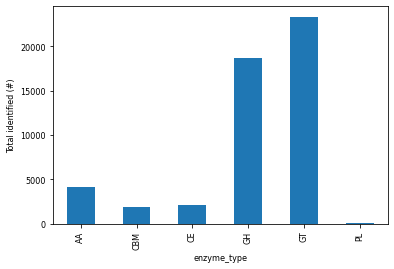

In [5]:
display(df.groupby(['enzyme_type'])['gene'].count())

df.groupby(['enzyme_type'])['gene'].count().plot(kind='bar')
plt.ylabel('Total identified (#)')

## Load existing phylogenetic tree

#### Get phylogenetic tree from tempo and mode of genome evolution paper

Paper doi: 10.1016/j.cell.2018.10.023

Data doi: 10.6084/m9.figshare.5854692

Figshare link: https://figshare.com/articles/Tempo_and_mode_of_genome_evolution_in_the_budding_yeast_subphylum/5854692

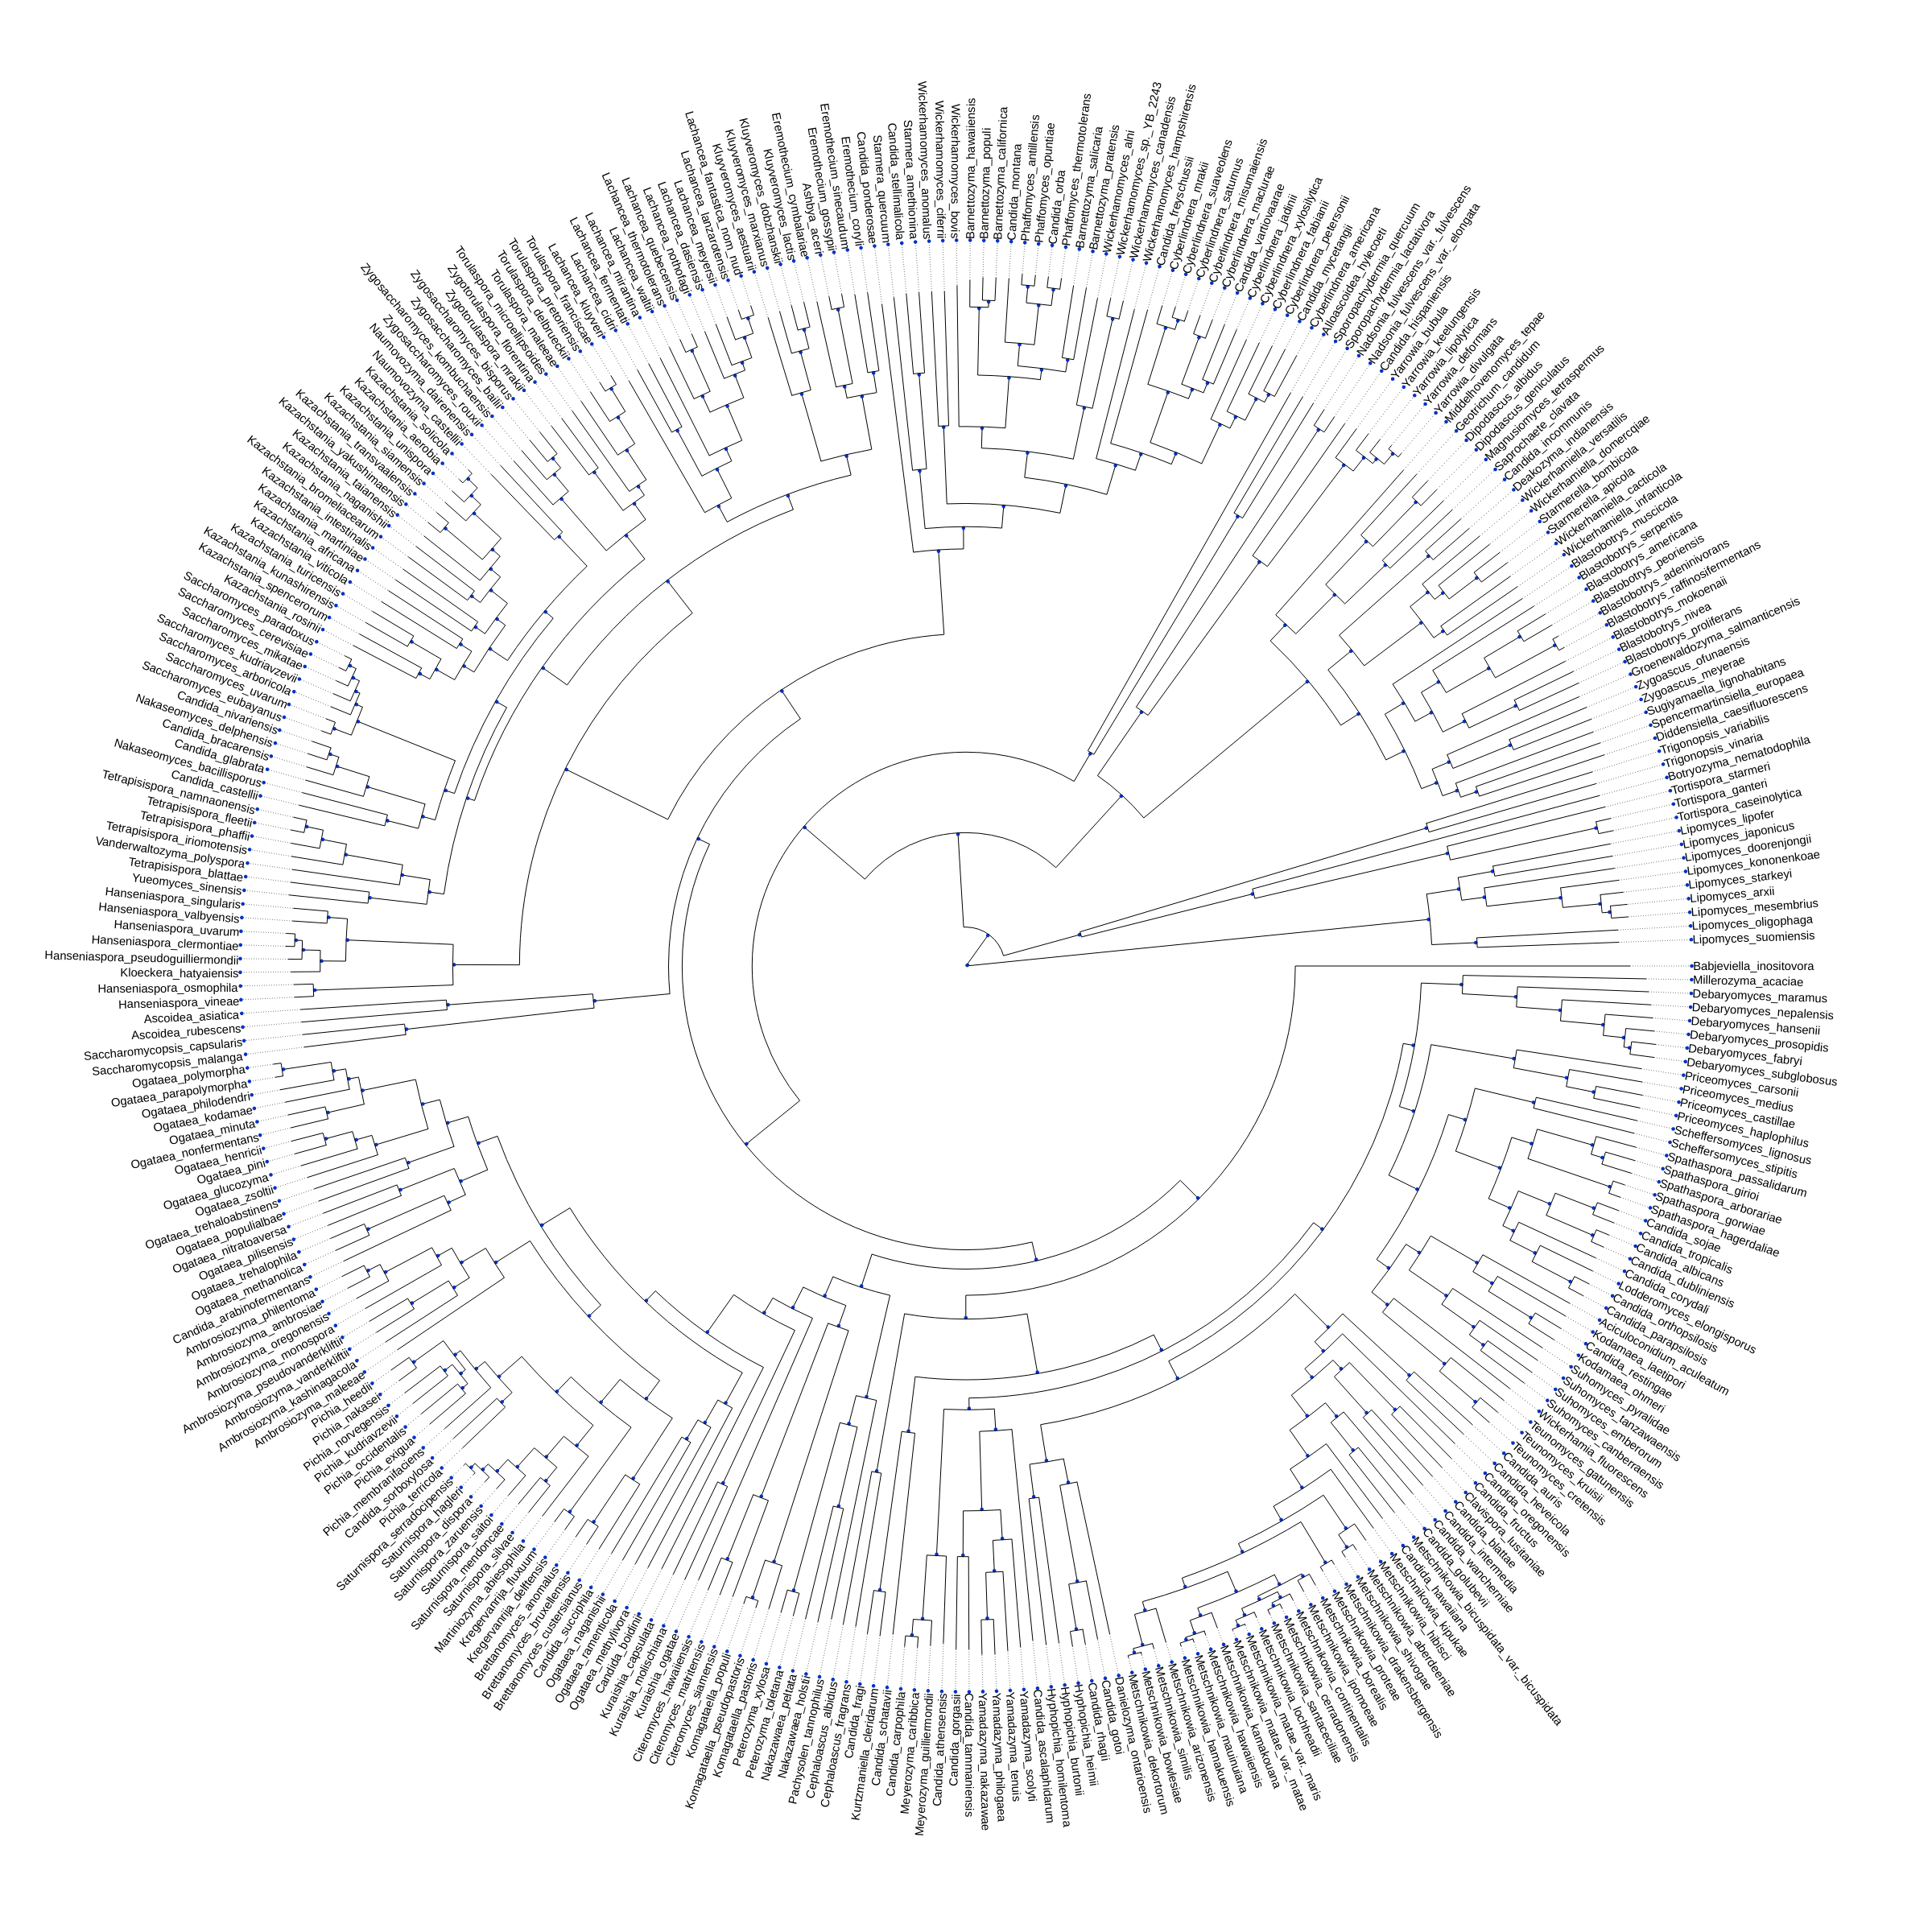

In [6]:
def norm_organism(orgname):
    '''
    Return abbreviated organism name
    '''
    orgname = orgname.replace('[', '').replace(']', '')
    
    # two organisms occur twice, deal with these special cases
    if orgname == 'Metschnikowia matae var. maris':
        return 'metschnikowia_matae_maris'
    
    elif orgname == 'Nadsonia fulvescens var. elongata':
        return 'nadsonia_fulvescens_var_elongata'
      
    # now parse filename for the others
    if orgname.startswith('yH'):
        organism = '_'.join(orgname.split()[1:3]).lower().replace('.', '')
    else:
        organism = '_'.join(orgname.split()[:2]).lower().replace('.', '')
    
    return organism


def translate_organism(orgname):
    '''
    The organism names are different between 
    my data file and that used in the phylogenetic tree.
    Translate my names to the ones used in the tree.
    '''
    dictionary = {'nadsonia_fulvescens':'nadsonia_fulvescens_var_fulvescens',
                 'magnusiomyces_tetrasperma':'magnusiomyces_tetraspermus',
                 'candida_versatilis':'wickerhamiella_versatilis',
                 'candida_infanticola':'wickerhamiella_infanticola',
                 'candida_salmanticensis':'groenewaldozyma_salmanticensis',
                 'hanseniaspora_vinae':'hanseniaspora_vineae',
                 'candida_apicola':'starmerella_apicola',
                 'arxula_adeninivorans':'blastobotrys_adeninivorans',
                 'blastobotrys_raffinofermentans':'blastobotrys_raffinosifermentans',
                 'candida_homilentoma':'hyphopichia_homilentoma',
                 'candida_azyma':'wickerhamomyces_sp_yb_2243',
                 'candida_tenuis':'yamadazyma_tenuis',
                 'nakaseomyces_castellii':'candida_castellii',
                 'ogataea_populiabae':'ogataea_populialbae',
                 'nakaseomyces_bracarensis':'candida_bracarensis',
                 'candida_pyralidae':'suhomyces_pyralidae',
                 'candida_gatunensis':'teunomyces_gatunensis',
                 'dekkera_bruxellensis':'brettanomyces_bruxellensis',
                 'nakaseomyces_nivariensis':'candida_nivariensis',
                 'candida_tanzawaensis':'suhomyces_tanzawaensis',
                 'candida_kruisii':'teunomyces_kruisii',
                 'candida_cretensis':'teunomyces_cretensis',
                 'metschnikowia_bicuspidata':'metschnikowia_bicuspidata_var_bicuspidata',
                 'lachancea_fantastica':'lachancea_fantastica_nom_nud',
                 'candida_emberorum':'suhomyces_emberorum',
                 'candida_canberraensis':'suhomyces_canberraensis',
                 'ogataea_philodendra':'ogataea_philodendri',
                 'metschnikowia_dekortum':'metschnikowia_dekortorum',
                 'metschnikowia_lockheadii':'metschnikowia_lochheadii',
                 'metschnikowia_matae_maris':'metschnikowia_matae_var_maris',
                 'metschnikowia_matae':'metschnikowia_matae_var_matae'}
    
    return dictionary.get(orgname)


def load_tree():
    filepath = join(RAW_EXTERNAL, 'phylo_tree', '332_2408OGs_time-calibrated_phylogeny_species-names_updated.newick')

    tree = Tree(filepath)

    ts = TreeStyle()
    ts.mode = "c"
    ts.scale = 175
    ts.show_scale = False
    
    return tree, ts


tree, ts = load_tree()

# save tree with the updated names
#tree.write(format=1, outfile=join('phylo_tree', '332_genomes_my_names.newick'))

tree.render("%%inline", dpi=600, w=2400, tree_style=ts)

#### Remove GT and count how many families are found in each organism

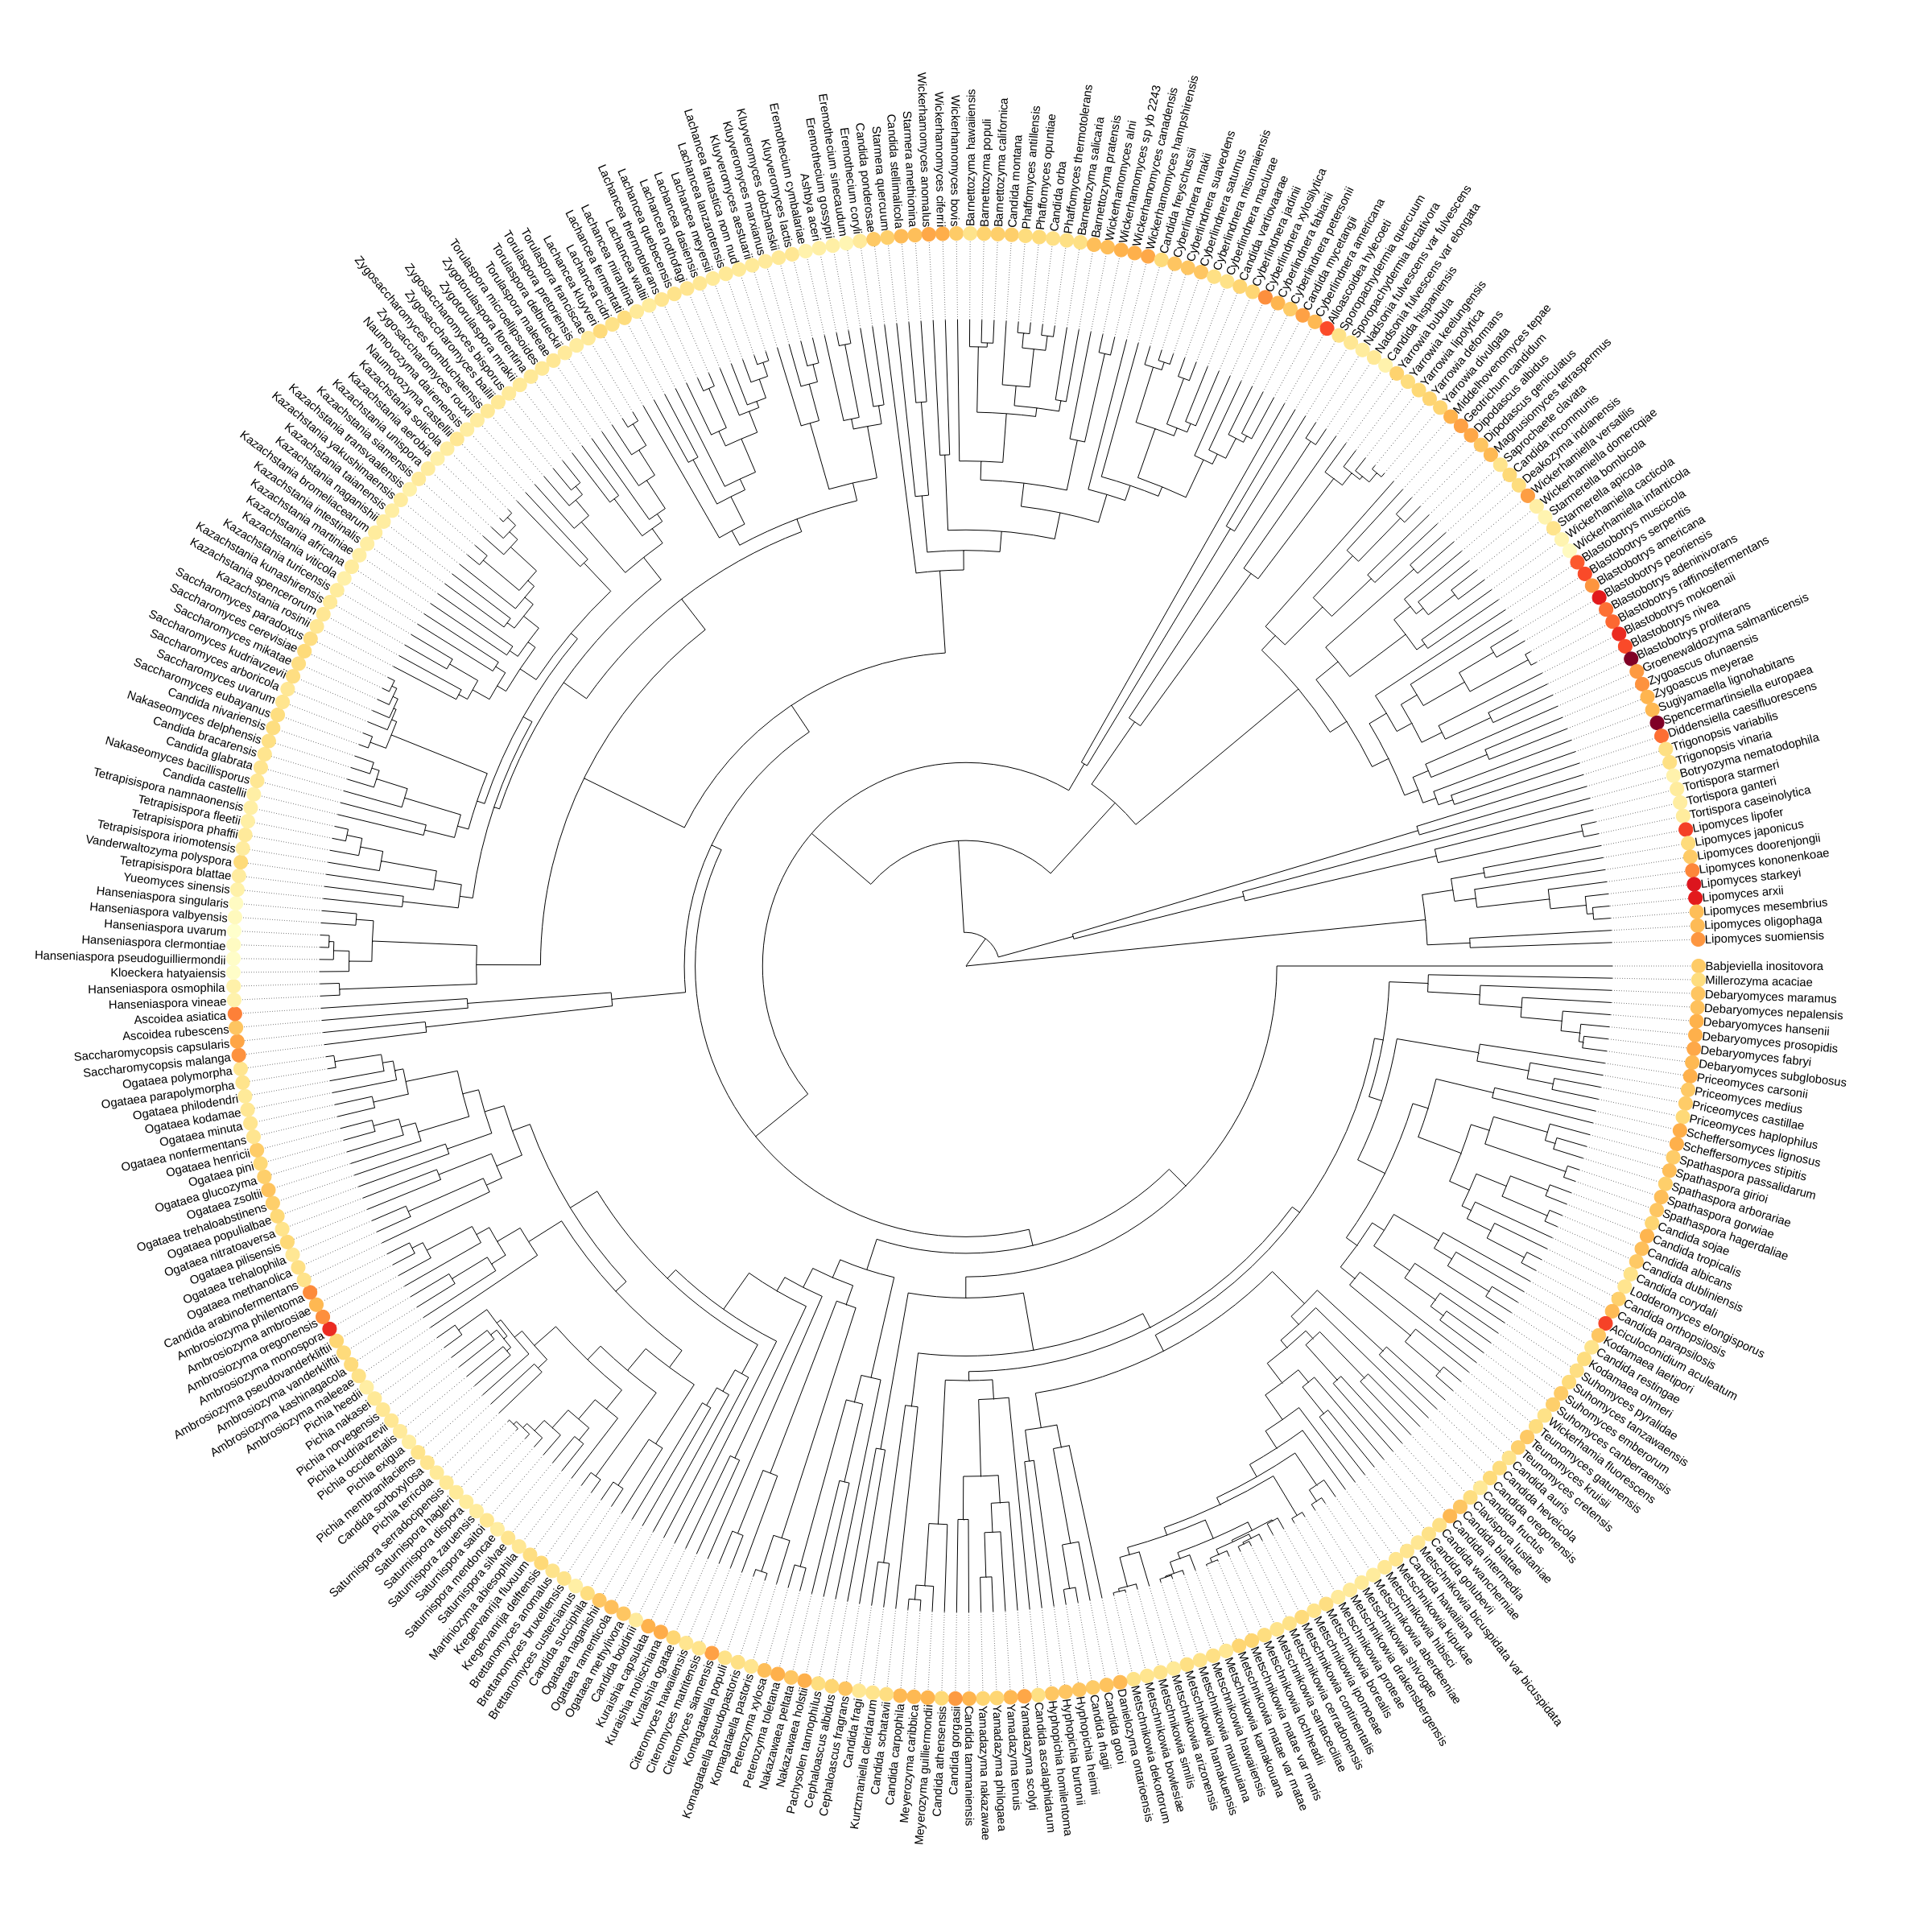

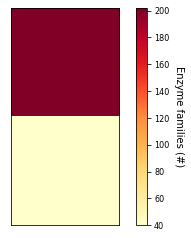

In [7]:
def color_tree(tree, data, cmap):
    # now add in keys for the alternate org names
    for name in sorted(data.keys()):
        alt_name = translate_organism(name)
        if alt_name is not None:
            data[alt_name] = data[name]
            
    orgs_with_data = data.keys()

    # setup a way to normalize values to the colormap
    norm = matplotlib.colors.Normalize(vmin=min(data.values()), vmax=max(data.values()))
    
    # go through and color the nodes according to how many enzymes they have
    for node in tree.traverse():
        # Hide node circles
        #node.img_style['size'] = 0

        if node.is_leaf():
            name = norm_organism(node.name)

            if not name in orgs_with_data:
                raise ValueError

            rgba = cmap(norm(data[name]))
            color = matplotlib.colors.to_hex(rgba, keep_alpha=False)


            # change the color of the leaf
            nstyle = NodeStyle()
            
#             nstyle["bgcolor"] = color
#             nstyle["size"] = 0

            nstyle["fgcolor"] = color
            nstyle["size"] = 15

            # add teh color
            node.set_style(nstyle)
            
            # make the name pretty
            node.name = name.replace('_', ' ').capitalize()
            
        else:
            # change the color of the node
            nstyle = NodeStyle()
            
            nstyle["size"] = 0    
            
            # apply
            node.set_style(nstyle)
            
    return tree
        
    
        

tree, ts = load_tree()
    
    
# count the families per organism (with excluding GT)
data = df[df.enzyme_type != 'GT'].groupby('organism')['family'].count().reset_index()

# convert data to a dictionary with organism keys and data values
data = data.set_index('organism')['family'].to_dict()

# setup colormap
cmap = matplotlib.cm.get_cmap('YlOrRd')
  
# add color to the tree
tree = color_tree(tree, data, cmap)



# define output filename
filename = '332_tree'

# save the colormap (scale) for this plot
mat = np.array([[min(data.values())], [max(data.values())]])
img = plt.imshow(mat, origin="lower", cmap=cmap, interpolation='nearest')
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar()
cbar.set_label('Enzyme families (#)', rotation=270, labelpad=15, fontsize=10)

plt.savefig(join(FIGURES, '{}_colorbar.png'.format(filename)))
plt.savefig(join(FIGURES, '{}_colorbar.pdf'.format(filename)))

# save pdf
tree.render(join(FIGURES, "{}.pdf".format(filename)), w=2400, tree_style=ts)

# save png
tree.render(join(FIGURES, "{}.png".format(filename)), w=2400, dpi=600, tree_style=ts)

# plot it
tree.render("%%inline", w=2400, dpi=100, tree_style=ts)


#### Make heatmap with substrates

In [8]:
# first I need to group the families according to the substrate they use
family_df = pd.read_csv(join(FINAL, '332_yeast_genomes_heatmap_data.tsv'), sep='\t')


# create a new data frame and set the organism name as index
substrate_df = pd.DataFrame(family_df.organism.values)
substrate_df.columns = ['Name']


# define substrate families
substrates = {'xylan':['GH3','GH5','GH11','GH30','GH43','GH51','GH62','GH67','GH115','CE1','CE3','CE4','CE5','CE12','CE15','CE16','CBM13'],
             'mannan':['GH2','GH5','GH26','GH27','GH76','GH125','GH134'],
             'xyloglucan':['GH2','GH3','GH5','GH12','GH16','GH29','GH31','GH35','GH42','GH45','GH74','GH95'],
             'beta-glucan':['GH3','GH16','GH55'],
             'lignin':['AA1','AA2','CE1','CE15'],
             'cellulose':['AA3','AA9','GH1','GH3','GH5','GH7','GH8','GH12','GH26','GH45','GH51','GH74','CBM1'],
             'chitin':['GH7','GH8','GH16','GH18','GH20','GH75','AA11','CE4','CBM18','CBM19','CBM32','CBM50'],
             'pectin':['PL1','PL3','PL4','PL26','GH28','GH78','CE8','GH106','GH139'],
             'starch':['GH13','GH15','GH31','GH63','CBM21'],}

#GH46???

# add in substrates
for sub in sorted(substrates.keys()):
    substrate_df[sub] = family_df[substrates[sub]].sum(axis=1)

    
    
#### Try to make organism names in substrate data match those in the tree #####
    
# go through and change the names to the alternate ones

for node in tree.traverse():
    if node.is_leaf():
        tree_name = node.name
        tree_norm_name = norm_organism(tree_name)
        

        for subst_name in substrate_df.Name:
            subst_alt_name = translate_organism(subst_name)
            
            if subst_alt_name is not None:
                search_name = subst_alt_name
            else:
                search_name = subst_name
                
            if search_name == tree_norm_name:
#                 print(subst_name, tree_name)
                substrate_df.loc[substrate_df.Name == subst_name, 'Name'] = tree_name

                
# change the index column
substrate_df = substrate_df.set_index('Name')


    
display(substrate_df.head())
display(substrate_df.tail())
display(substrate_df.describe())

# save data
substrate_df.to_csv(join(FINAL, '332_yeast_genomes_heatmap_data_substrates_tree_names.tsv'), sep='\t', index_label='#Names')

,beta-glucan,cellulose,chitin,lignin,mannan,pectin,starch,xylan,xyloglucan
Name,,,,,,,,,
Aciculoconidium aculeatum,10.0,9.0,67.0,7.0,12.0,0.0,8.0,9.0,16.0
Alloascoidea hylecoeti,13.0,31.0,19.0,9.0,23.0,11.0,12.0,19.0,39.0
Ambrosiozyma ambrosiae,10.0,18.0,10.0,9.0,18.0,1.0,13.0,16.0,26.0
Ambrosiozyma kashinagacola,4.0,9.0,7.0,8.0,12.0,0.0,9.0,8.0,14.0
Ambrosiozyma maleeae,4.0,9.0,8.0,7.0,11.0,0.0,8.0,8.0,12.0


,beta-glucan,cellulose,chitin,lignin,mannan,pectin,starch,xylan,xyloglucan
Name,,,,,,,,,
Zygosaccharomyces bisporus,5.0,7.0,8.0,7.0,5.0,0.0,8.0,5.0,13.0
Zygosaccharomyces kombuchaensis,5.0,8.0,8.0,7.0,6.0,0.0,10.0,6.0,13.0
Zygosaccharomyces rouxii,3.0,9.0,6.0,6.0,6.0,0.0,9.0,6.0,12.0
Zygotorulaspora florentina,4.0,5.0,8.0,8.0,7.0,0.0,13.0,6.0,10.0
Zygotorulaspora mrakii,5.0,6.0,8.0,8.0,7.0,0.0,9.0,7.0,12.0


,beta-glucan,cellulose,chitin,lignin,mannan,pectin,starch,xylan,xyloglucan
count,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000
mean,7.234940,12.313253,9.701807,6.072289,10.822289,0.855422,10.210843,11.171687,16.816265
std,3.480491,6.241713,4.848608,1.759107,4.613953,1.874507,3.145630,4.990993,6.902820
min,1.000000,2.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,5.000000
25%,4.000000,8.000000,7.000000,5.000000,8.000000,0.000000,8.000000,7.000000,12.000000
50%,7.000000,11.000000,9.000000,6.000000,10.000000,0.000000,10.000000,10.000000,16.000000
75%,10.000000,15.000000,11.000000,7.000000,13.000000,1.000000,11.250000,14.000000,20.000000
max,19.000000,37.000000,67.000000,14.000000,37.000000,15.000000,31.000000,35.000000,54.000000


#### Plot all the organisms

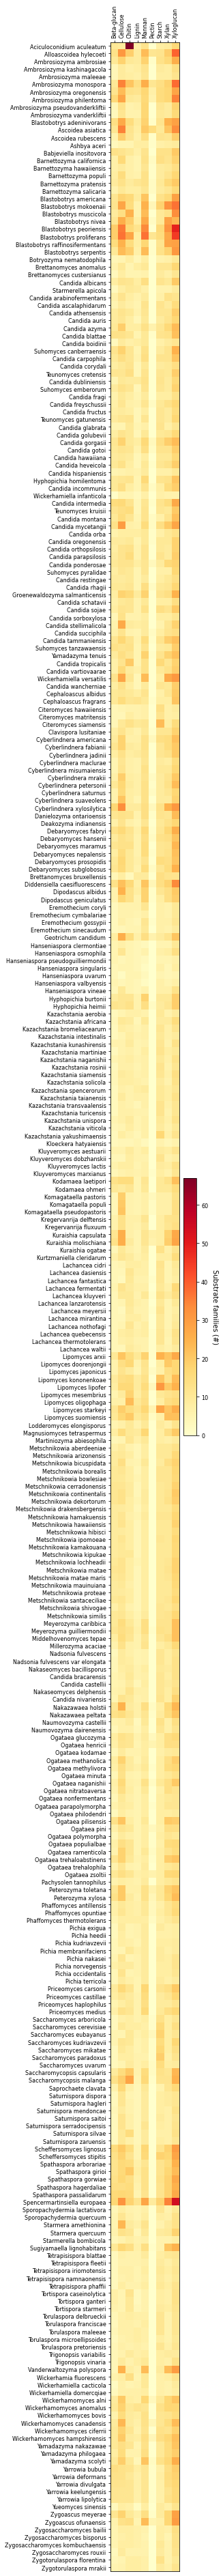

In [9]:
# get the organism names and substrate names
y_labels = [s.replace('_', ' ').capitalize() for s in substrate_df.index]
x_labels = [s.capitalize() for s in substrate_df.columns]

# setup the heatmap
fig, ax = plt.subplots(1,1, figsize=(0.25*len(x_labels), 0.25*len(y_labels)))
img = ax.imshow(substrate_df.to_numpy(), cmap='YlOrRd')

# add names 
ax.xaxis.tick_top()
ax.set_xticks(np.arange(0, len(x_labels)))
ax.set_yticks(np.arange(0, len(y_labels)))
ax.set_xticklabels(x_labels, rotation=90)
ax.set_yticklabels(y_labels)

# add the colorbar
cbar = fig.colorbar(img, shrink=0.35)
cbar.set_label('Substrate families (#)', rotation=270, labelpad=15, fontsize=10)

filename = 'all_orgs_substrate_families'
plt.savefig(join(FIGURES, '{}.png'.format(filename)))
plt.savefig(join(FIGURES, '{}.pdf'.format(filename)))

#### Plot only the selected organisms

In [10]:
# chosen_orgs = ['aciculoconidium_aculeatum',
#          'ambrosiozyma_ambrosiae',
#          'ambrosiozyma_monospora',
#          'ambrosiozyma_oregonensis',
#          'ambrosiozyma_philentoma',
#          'ascoidea_asiatica',
#          'ascoidea_rubescens',
#          'arxula_adeninivorans', # actually 'blastobotrys_adeninivorans'
#          'blastobotrys_americana',
#          'blastobotrys_mokoenaii',
#          'blastobotrys_muscicola',
#          'blastobotrys_nivea',
#          'blastobotrys_peoriensis',
#          'blastobotrys_proliferans',
#          'blastobotrys_raffinofermentans',
#          'blastobotrys_serpentis',
#          'candida_gorgasii',
#          'debaryomyces_fabryi',
#          'debaryomyces_maramus',
#          'debaryomyces_nepalensis',
#          'debaryomyces_prosopidis',
#          'debaryomyces_subglobosus',
#          'diddensiella_caesifluorescens',
#          'lipomyces_arxii',
#          'lipomyces_doorenjongii',
#          'lipomyces_kononenkoae',
#          'lipomyces_lipofer',
#          'lipomyces_starkeyi',
#          'saccharomycopsis_capsularis',
#          'saccharomycopsis_malanga',
#          'scheffersomyces_lignosus',
#          'scheffersomyces_stipitis',
#          'spathaspora_passalidarum',
#          'spencermartinsiella_europaea',
#          'sugiyamaella_lignohabitans',
#          'wickerhamomyces_anomalus',
#          'wickerhamomyces_canadensis',
#          'wickerhamomyces_ciferrii',
#          'wickerhamomyces_hampshirensis']



chosen_orgs = ['lipomyces_starkeyi',
                 'lipomyces_arxii',
                 'lipomyces_kononenkoae',
                 'lipomyces_lipofer',
                 'lipomyces_doorenjongii',
                 'spencermartinsiella_europaea',
                 'sugiyamaella_lignohabitans',
                 'diddensiella_caesifluorescens',
                 'blastobotrys_peoriensis',
                 'blastobotrys_nivea',
                 'blastobotrys_muscicola',
                 'blastobotrys_mokoenaii',
                 'blastobotrys_americana',
                 'arxula_adeninivorans',
                 'blastobotrys_proliferans',
                 'blastobotrys_serpentis',
                 'blastobotrys_raffinofermentans',
                 'ambrosiozyma_philentoma',
                 'ambrosiozyma_ambrosiae',
                 'ambrosiozyma_monospora',
                 'ambrosiozyma_oregonensis',
                 'spathaspora_passalidarum',
                 'debaryomyces_subglobosus',
                 'debaryomyces_fabryi',
                 'debaryomyces_prosopidis',
                 'debaryomyces_hansenii',
                 'debaryomyces_nepalensis',
                 'candida_gorgasii',
                 'debaryomyces_maramus',
                 'scheffersomyces_lignosus',
                 'scheffersomyces_stipitis',
                 'aciculoconidium_aculeatum',
                 'wickerhamomyces_anomalus',
                 'wickerhamomyces_ciferrii',
                 'wickerhamomyces_canadensis',
                 'wickerhamomyces_hampshirensis',
                 'saccharomycopsis_capsularis',
                 'saccharomycopsis_malanga',
                 'ascoidea_asiatica',
                 'ascoidea_rubescens']

# first I need to group the families according to the substrate they use
family_df = pd.read_csv(join(FINAL, '332_yeast_genomes_heatmap_data.tsv'), sep='\t')


# create a new data frame and set the organism name as index
substrate_df = pd.DataFrame(family_df.organism.values)
substrate_df.columns = ['Name']



# add in substrates
for sub in sorted(substrates.keys()):
    substrate_df[sub] = family_df[substrates[sub]].sum(axis=1)



# change the index column
substrate_df = substrate_df.set_index('Name')
    
display(substrate_df.head())
display(substrate_df.tail())
display(substrate_df.describe())




# save data
substrate_df.to_csv(join(FINAL, '332_yeast_genomes_heatmap_data_substrates.tsv'), sep='\t', index_label='#Names')

,beta-glucan,cellulose,chitin,lignin,mannan,pectin,starch,xylan,xyloglucan
Name,,,,,,,,,
aciculoconidium_aculeatum,10.0,9.0,67.0,7.0,12.0,0.0,8.0,9.0,16.0
alloascoidea_hylecoeti,13.0,31.0,19.0,9.0,23.0,11.0,12.0,19.0,39.0
ambrosiozyma_ambrosiae,10.0,18.0,10.0,9.0,18.0,1.0,13.0,16.0,26.0
ambrosiozyma_kashinagacola,4.0,9.0,7.0,8.0,12.0,0.0,9.0,8.0,14.0
ambrosiozyma_maleeae,4.0,9.0,8.0,7.0,11.0,0.0,8.0,8.0,12.0


,beta-glucan,cellulose,chitin,lignin,mannan,pectin,starch,xylan,xyloglucan
Name,,,,,,,,,
zygosaccharomyces_bisporus,5.0,7.0,8.0,7.0,5.0,0.0,8.0,5.0,13.0
zygosaccharomyces_kombuchaensis,5.0,8.0,8.0,7.0,6.0,0.0,10.0,6.0,13.0
zygosaccharomyces_rouxii,3.0,9.0,6.0,6.0,6.0,0.0,9.0,6.0,12.0
zygotorulaspora_florentina,4.0,5.0,8.0,8.0,7.0,0.0,13.0,6.0,10.0
zygotorulaspora_mrakii,5.0,6.0,8.0,8.0,7.0,0.0,9.0,7.0,12.0


,beta-glucan,cellulose,chitin,lignin,mannan,pectin,starch,xylan,xyloglucan
count,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000
mean,7.234940,12.313253,9.701807,6.072289,10.822289,0.855422,10.210843,11.171687,16.816265
std,3.480491,6.241713,4.848608,1.759107,4.613953,1.874507,3.145630,4.990993,6.902820
min,1.000000,2.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,5.000000
25%,4.000000,8.000000,7.000000,5.000000,8.000000,0.000000,8.000000,7.000000,12.000000
50%,7.000000,11.000000,9.000000,6.000000,10.000000,0.000000,10.000000,10.000000,16.000000
75%,10.000000,15.000000,11.000000,7.000000,13.000000,1.000000,11.250000,14.000000,20.000000
max,19.000000,37.000000,67.000000,14.000000,37.000000,15.000000,31.000000,35.000000,54.000000


In [11]:
for org in chosen_orgs:
    if org not in substrate_df.index:
        [print(org)]


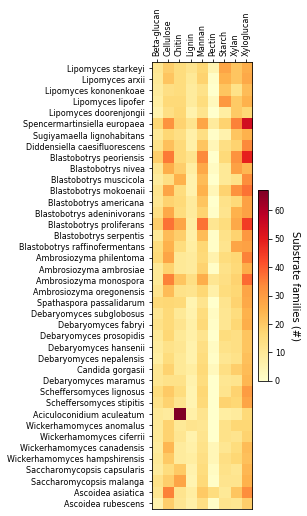

In [12]:
substrate_df_chosen = substrate_df.loc[chosen_orgs]

# get the organism names and substrate names
y_labels = [s.replace('arxula_adeninivorans', 'blastobotrys_adeninivorans').replace('_', ' ').capitalize() 
            for s in substrate_df_chosen.index]
x_labels = [s.capitalize() for s in substrate_df.columns]

# setup the heatmap
fig, ax = plt.subplots(1,1, figsize=(0.25*len(x_labels), 0.25*len(y_labels)))
img = ax.imshow(substrate_df_chosen.to_numpy(), cmap='YlOrRd')

# add names 
ax.xaxis.tick_top()
ax.set_xticks(np.arange(0, len(x_labels)))
ax.set_yticks(np.arange(0, len(y_labels)))
ax.set_xticklabels(x_labels, rotation=90)
ax.set_yticklabels(y_labels)

# add the colorbar
cbar = fig.colorbar(img, shrink=0.35)
cbar.set_label('Substrate families (#)', rotation=270, labelpad=15, fontsize=10)

filename = 'selected_orgs_substrate_families'
plt.savefig(join(FIGURES, '{}.png'.format(filename)), pad_inches=3)
plt.savefig(join(FIGURES, '{}.pdf'.format(filename)), pad_inches=3)